# Backpropagation

This example demonstrates all steps starting from forward pass to backward pass. We will be settings the initial weights manually to make manual computations easy.

Remember that we are asking the question:

> “If I make a tiny change to this specific weight $w_{ij}$, how much will the loss $L$ change — keeping everything else constant?”

That *constant* part is important. When we compute the derivative of the loss with respect to a specific weight, we are assuming that all other weights and biases remain unchanged. The computed numbers are called *partial derivatives* for this reason. If you put these into a vector or matrix, you get the *gradient* of the loss with respect to the weights. So the gradient is just a collection of partial derivatives.

In [1]:
import torch
import torch.nn as nn

## Architecture and Data

We will choose a simple 3-2-1 architecture with ReLU activations and Mean Squared Error loss. To start, let's define the input data, weights, biases and target output.

In [2]:
# Input data
x_sample = torch.tensor([[0.1, 0.2, 0.3]], dtype=torch.float32)

# Weights
W0 = torch.tensor([[0.4, 0.5, 0.6],
                   [0.7, 0.8, 0.9]], dtype=torch.float32, requires_grad=True)
W1 = torch.tensor([[1.0, 1.1]], dtype=torch.float32, requires_grad=True)

# Biases
b0 = torch.tensor([[0.1],
                   [0.2]], dtype=torch.float32, requires_grad=True)
b1 = torch.tensor([[0.3]], dtype=torch.float32, requires_grad=True)

# Target output
y_target = torch.tensor([[1.0]], dtype=torch.float32)

## Model

Now, we can define the model class (simple feedforward neural network) that also stores intermediate values for inspection during backpropagation.

In [3]:
class SimpleNetwork:
    
    def __init__(self, W0, b0, W1, b1):
        """Initialize with pre-defined weights and biases."""
        self.W0, self.b0 = W0, b0
        self.W1, self.b1 = W1, b1
        
        # Store intermediate values for inspection
        self.z0 = torch.tensor([[.0, .0]])  # Linear output of hidden layer
        self.a0 = torch.tensor([[.0, .0]])  # Activated output of hidden layer (after ReLU)
        self.z1 = torch.tensor([[.0]])      # Linear output of output layer

    def forward(self, x):
        self.z0 = x @ self.W0.T + self.b0.T
        self.a0 = torch.relu(self.z0)
        self.z1 = self.a0 @ self.W1.T + self.b1.T
        
        return self.z1

### Forward Pass

We have covered the forward pass before, so we will simply run the model.

In [4]:
# Create the network
model = SimpleNetwork(W0, b0, W1, b1)

# Forward pass
y_pred = model.forward(x_sample)

# Compute loss
loss = nn.MSELoss()(y_pred, y_target)
print(f"Loss: {loss.item()}")

# Backward pass
loss.backward()

# Check gradients
print(f"W0.grad: {W0.grad}")
print(f"W1.grad: {W1.grad}")

Loss: 0.24010001122951508
W0.grad: tensor([[0.0980, 0.1960, 0.2940],
        [0.1078, 0.2156, 0.3234]])
W1.grad: tensor([[0.4116, 0.6860]])


Let's draw the computational graph for better understanding:

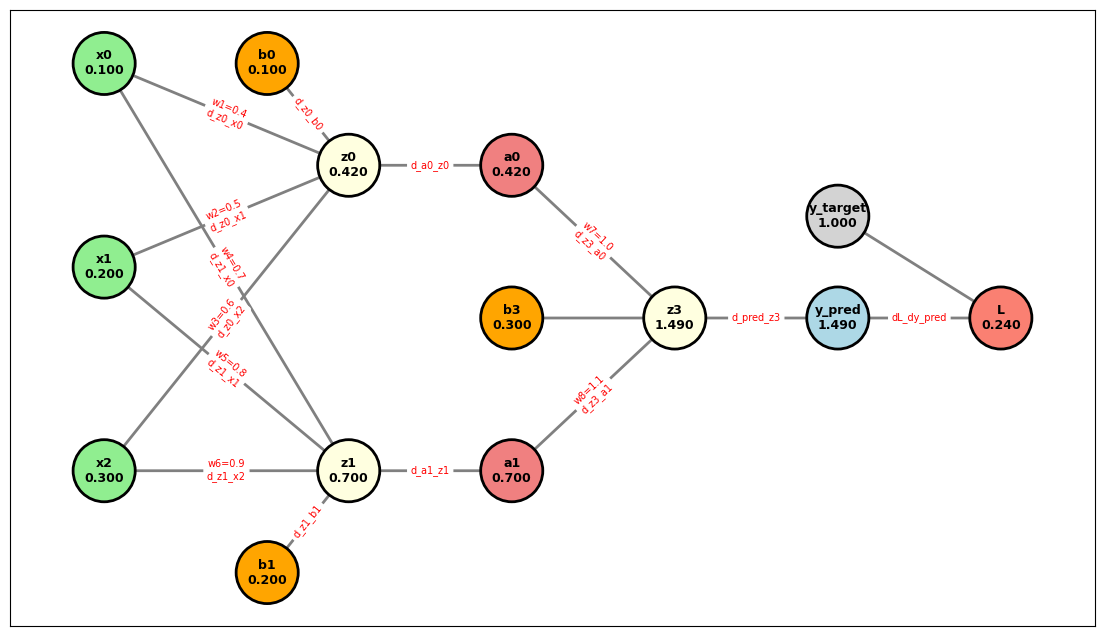

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract values from model
x_vals = x_sample[0].detach().numpy()
z0_vals = model.z0[0].detach().numpy()
a0_vals = model.a0[0].detach().numpy()
z1_val = model.z1[0, 0].item()
y_pred_val = y_pred[0, 0].item()
loss_val = loss.item()

# Create directed graph
G = nx.DiGraph()

# Define nodes
nodes = {
    'x0': {'layer': 0, 'pos': (0, 8), 'value': x_vals[0], 'color': 'lightgreen'},
    'x1': {'layer': 0, 'pos': (0, 6), 'value': x_vals[1], 'color': 'lightgreen'},
    'x2': {'layer': 0, 'pos': (0, 4), 'value': x_vals[2], 'color': 'lightgreen'},
    'z0': {'layer': 1, 'pos': (3, 7), 'value': z0_vals[0], 'color': 'lightyellow'},
    'z1': {'layer': 1, 'pos': (3, 4), 'value': z0_vals[1], 'color': 'lightyellow'},
    'b0': {'layer': 1, 'pos': (2, 8), 'value': b0[0, 0].item(), 'color': 'orange'},
    'b1': {'layer': 1, 'pos': (2, 3), 'value': b0[1, 0].item(), 'color': 'orange'},
    'a0': {'layer': 2, 'pos': (5, 7), 'value': a0_vals[0], 'color': 'lightcoral'},
    'a1': {'layer': 2, 'pos': (5, 4), 'value': a0_vals[1], 'color': 'lightcoral'},
    'b3': {'layer': 2, 'pos': (5, 5.5), 'value': b1[0, 0].item(), 'color': 'orange'},
    'z3': {'layer': 3, 'pos': (7, 5.5), 'value': z1_val, 'color': 'lightyellow'},
    'y_pred': {'layer': 4, 'pos': (9, 5.5), 'value': y_pred_val, 'color': 'lightblue'},
    'y_target': {'layer': 4, 'pos': (9, 6.5), 'value': y_target.item(), 'color': 'lightgray'},
    'L': {'layer': 5, 'pos': (11, 5.5), 'value': loss_val, 'color': 'salmon'}
}

# Add nodes to graph
for node_id, attrs in nodes.items():
    G.add_node(node_id, **attrs)

edges = [
    # Input to hidden layer
    ('x0', 'z0', {'name': 'w1', 'weight': W0[0, 0].item(), 'grad': 'd_z0_x0'}), # 0.1
    ('x1', 'z0', {'name': 'w2', 'weight': W0[0, 1].item(), 'grad': 'd_z0_x1'}), # 0.2
    ('x2', 'z0', {'name': 'w3', 'weight': W0[0, 2].item(), 'grad': 'd_z0_x2'}), # 0.3
    ('x0', 'z1', {'name': 'w4', 'weight': W0[1, 0].item(), 'grad': 'd_z1_x0'}), # 0.1
    ('x1', 'z1', {'name': 'w5', 'weight': W0[1, 1].item(), 'grad': 'd_z1_x1'}), # 0.2
    ('x2', 'z1', {'name': 'w6', 'weight': W0[1, 2].item(), 'grad': 'd_z1_x2'}), # 0.3
    # Biases to hidden layer
    ('b0', 'z0', {'weight': None, 'grad': 'd_z0_b0'}), # 0.1
    ('b1', 'z1', {'weight': None, 'grad': 'd_z1_b1'}), # 0.2
    # Activation
    ('z0', 'a0', {'weight': None, 'grad': 'd_a0_z0'}), # 1 (assuming ReLU active)
    ('z1', 'a1', {'weight': None, 'grad': 'd_a1_z1'}), # 1 (assuming ReLU active)
    # Hidden to output
    ('a0', 'z3', {'name': 'w7', 'weight': W1[0, 0].item(), 'grad': 'd_z3_a0'}), # 0.42
    ('a1', 'z3', {'name': 'w8', 'weight': W1[0, 1].item(), 'grad': 'd_z3_a1'}), # 0.7
    # Bias to output
    ('b3', 'z3', {'weight': None, 'grad': ''}), # 
    # Output to prediction
    ('z3', 'y_pred', {'weight': None, 'grad': 'd_pred_z3'}), # 1
    # Target to loss
    ('y_target', 'L', {'weight': None, 'grad': ''}), # Not needed
    # Prediction to loss
    ('y_pred', 'L', {'weight': None, 'grad': 'dL_dy_pred'}), # 0.98
]

G.add_edges_from([(u, v, _) for u, v, _ in edges])

# Prepare positions and labels
pos = {node: attrs['pos'] for node, attrs in nodes.items()}
node_colors = [attrs['color'] for _, attrs in nodes.items()]

# Create labels with values
labels = {}
for node, attrs in nodes.items():
    if attrs['value'] is not None:
        labels[node] = f"{node}\n{attrs['value']:.3f}"
    else:
        labels[node] = node

# Draw the graph
fig, ax = plt.subplots(figsize=(14, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                       node_size=2000, node_shape='o',
                       edgecolors='black', linewidths=2, ax=ax)

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20,
                       edge_color='gray', width=2, ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold', ax=ax)

# Draw edge labels (weights and gradients)
edge_labels = {}
for u, v, d in edges:
    if d['weight'] is not None:
        edge_labels[(u, v)] = f"{d['name']}={d['weight']:.1f}\n{d['grad']}"
    else:
        edge_labels[(u, v)] = d['grad']

nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7,
                             font_color='red', ax=ax)

plt.show()

## Step by step replication of forward and backward pass calculations

Ok, now we know that the gradients w.r.t. weights are stored in W0.grad and W1.grad after backpropagation. Let's start mimicing what PyTorch did. We will start this work from the input layer and move forward to compute all intermediate values. After this, we will start from the loss and move backwards to compute all gradients step by step.

### List of variables we will compute:

**Input to Hidden Layer (W0 weights):**
- `d_z0_x0`, `d_z0_x1`, `d_z0_x2` - Partial derivatives of hidden neuron 0's linear output w.r.t. first row of W0
- `d_z1_x0`, `d_z1_x1`, `d_z1_x2` - Partial derivatives of hidden neuron 1's linear output w.r.t. second row of W0
- `d_z0_b0` - Partial derivative of hidden neuron 0
- `d_z1_b1` - Partial derivative of hidden neuron 1

**Hidden Layer Activation (ReLU):**
- `d_a0_z0` - Derivative of ReLU for hidden neuron 0 (1 if z0_0 > 0, else 0)
- `d_a1_z1` - Derivative of ReLU for hidden neuron 1 (1 if z0_1 > 0, else 0)

**Hidden to Output Layer (W1 weights):**
- `d_z3_a0` - Partial derivative of output w.r.t. W1[0,0] (equals a0_0)
- `d_z3_a1` - Partial derivative of output w.r.t. W1[0,1] (equals a0_1)
- `dz1_da0_0` - Partial derivative of output w.r.t. activated hidden neuron 0 (equals W1[0,0])
- `dz1_da0_1` - Partial derivative of output w.r.t. activated hidden neuron 1 (equals W1[0,1])

**Output Layer (no activation):**
- `d_pred_z3` - Derivative of prediction w.r.t. linear output (equals 1, identity function)

**Loss Function (MSE):**
- `dL_dy_pred` - Gradient of loss w.r.t. prediction (equals 2*(y_pred - y_target))

**Final Gradients (using chain rule):**
- `dL_dW0_00`, `dL_dW0_01`, `dL_dW0_02` - Full gradients for first row of W0 (hidden neuron 0)
- `dL_dW0_10`, `dL_dW0_11`, `dL_dW0_12` - Full gradients for second row of W0 (hidden neuron 1)
- `dL_dW1_00`, `dL_dW1_01` - Full gradients for W1


### Input to Hidden Layer: dz0_x_dW0_xx

We will start by computing the partial derivatives of the linear outputs of the hidden layer neurons w.r.t. their weights in W0.

In [30]:
# For hidden neuron 0 (first row of W0)
W0_0 = W0[0].detach().clone()       # is [0.4000, 0.5000, 0.6000]
W0_0.requires_grad_(True)
z0_0 = W0_0 @ x_sample.T + b0[0]    # is [0.420]
z0_0.backward()

d_z0_x0 = W0_0.grad[0].item()  # Should equal x[0] = 0.1
d_z0_x1 = W0_0.grad[1].item()  # Should equal x[1] = 0.2
d_z0_x2 = W0_0.grad[2].item()  # Should equal x[2] = 0.3

# For hidden neuron 1 (second row of W0)
W0_1 = W0[1].detach().clone()
W0_1.requires_grad_(True)
z0_1 = W0_1 @ x_sample.T + b0[1]
z0_1.backward()

d_z1_x0 = W0_1.grad[0].item()  # Should equal x[0] = 0.1
d_z1_x1 = W0_1.grad[1].item()  # Should equal x[1] = 0.2
d_z1_x2 = W0_1.grad[2].item()  # Should equal x[2] = 0.3

# Also the biases in hidden layer
b0_0 = b0[0].detach().clone()
b0_0.requires_grad_(True)
z0_0_b = W0[0] @ x_sample.T + b0_0
z0_0_b.backward()
d_z0_b0 = b0_0.grad.item()  # Should equal 1

b0_1 = b0[1].detach().clone()
b0_1.requires_grad_(True)
z0_1_b = W0[1] @ x_sample.T + b0_1
z0_1_b.backward()
d_z1_b1 = b0_1.grad.item()  # Should equal 1

print("=== Partial Derivatives: Input to Hidden Layer ===")
print(f"dz0/dx0 = {d_z0_x0:.4f} (expected: {x_sample[0, 0].item():.4f})")
print(f"dz0/dx1 = {d_z0_x1:.4f} (expected: {x_sample[0, 1].item():.4f})")
print(f"dz0/dx2 = {d_z0_x2:.4f} (expected: {x_sample[0, 2].item():.4f})")
print(f"dz1/dx0 = {d_z1_x0:.4f} (expected: {x_sample[0, 0].item():.4f})")
print(f"dz1/dx1 = {d_z1_x1:.4f} (expected: {x_sample[0, 1].item():.4f})")
print(f"dz1/dx2 = {d_z1_x2:.4f} (expected: {x_sample[0, 2].item():.4f})")
print(f"dz0/db0 = {d_z0_b0:.4f} (expected: 1.0000)")
print(f"dz1/db1 = {d_z1_b1:.4f} (expected: 1.0000)")

=== Partial Derivatives: Input to Hidden Layer ===
dz0/dx0 = 0.1000 (expected: 0.1000)
dz0/dx1 = 0.2000 (expected: 0.2000)
dz0/dx2 = 0.3000 (expected: 0.3000)
dz1/dx0 = 0.1000 (expected: 0.1000)
dz1/dx1 = 0.2000 (expected: 0.2000)
dz1/dx2 = 0.3000 (expected: 0.3000)
dz0/db0 = 1.0000 (expected: 1.0000)
dz1/db1 = 1.0000 (expected: 1.0000)


In [7]:
x_sample

tensor([[0.1000, 0.2000, 0.3000]])

### Hidden Layer Activation (ReLU): da0_x_dz0_x

ReLU activation is super simple to derivate. If the input is greater than zero, the derivative is 1, otherwise it is 0.

In [ ]:
# Compute derivatives of ReLU activation
# ReLU derivative: 1 if input > 0, else 0

# For hidden neuron 0
z0_0_clone = model.z0[0][0].detach().clone()
z0_0_clone.requires_grad_(True)
a0_0_clone = torch.relu(z0_0_clone)
a0_0_clone.backward()

d_a0_z0 = z0_0_clone.grad.item()  # Should be 1 (since z0_0 > 0)

# For hidden neuron 1
z0_1_clone = model.z0[0][1].detach().clone()
z0_1_clone.requires_grad_(True)
a0_1_clone = torch.relu(z0_1_clone)
a0_1_clone.backward()

d_a1_z1 = z0_1_clone.grad.item()  # Should be 1 (since z0_1 > 0)

print("=== Partial Derivatives: Hidden Layer Activation (ReLU) ===")
print(f"da0_0/dz0_0 = {d_a0_z0:.4f} (ReLU derivative, 1 if z0_0 > 0)")
print(f"da0_1/dz0_1 = {d_a1_z1:.4f} (ReLU derivative, 1 if z0_1 > 0)")
print(f"\nActual z0 values: z0_0 = {model.z0[0][0].item():.4f}, z0_1 = {model.z0[0][1].item():.4f}")

=== Partial Derivatives: Hidden Layer Activation (ReLU) ===
da0_0/dz0_0 = 1.0000 (ReLU derivative, 1 if z0_0 > 0)
da0_1/dz0_1 = 1.0000 (ReLU derivative, 1 if z0_1 > 0)

Actual z0 values: z0_0 = 0.4200, z0_1 = 0.7000


### Hidden to Output Layer

Compute partial derivatives for hidden to output layer. We need:

* `d_z3_a0`, `d_z3_a1` - Partial derivatives of output w.r.t. W1 weights
* `dz1_da0_0`, `dz1_da0_1` - Partial derivatives of output w.r.t. activated hidden neurons

In [ ]:
# Compute partial derivatives for hidden to output layer
# We need: dz1/dW1_00, dz1/dW1_01, dz1/da0_0, dz1/da0_1

# Gradients w.r.t. W1 weights
W1_clone = W1.detach().clone()
W1_clone.requires_grad_(True)
a0_detached = model.a0.detach().clone()
z1_clone = a0_detached @ W1_clone.T + b1.T
z1_clone.backward()

d_z3_a0 = W1_clone.grad[0, 0].item()  # Should equal a0_0
d_z3_a1 = W1_clone.grad[0, 1].item()  # Should equal a0_1

# Gradients w.r.t. activated hidden layer outputs
W1_detached = W1.detach().clone()
a0_clone = model.a0.detach().clone()
a0_clone.requires_grad_(True)
z1_from_a0 = a0_clone @ W1_detached.T + b1.T
z1_from_a0.backward()

dz1_da0_0 = a0_clone.grad[0, 0].item()  # Should equal W1[0, 0]
dz1_da0_1 = a0_clone.grad[0, 1].item()  # Should equal W1[0, 1]

print("=== Partial Derivatives: Hidden to Output Layer ===")
print(f"dz1/dW1_00 = {d_z3_a0:.4f} (expected: {model.a0[0, 0].item():.4f})")
print(f"dz1/dW1_01 = {d_z3_a1:.4f} (expected: {model.a0[0, 1].item():.4f})")
print(f"dz1/da0_0 = {dz1_da0_0:.4f} (expected: {W1[0, 0].item():.4f})")
print(f"dz1/da0_1 = {dz1_da0_1:.4f} (expected: {W1[0, 1].item():.4f})")

=== Partial Derivatives: Hidden to Output Layer ===
dz1/dW1_00 = 0.4200 (expected: 0.4200)
dz1/dW1_01 = 0.7000 (expected: 0.7000)
dz1/da0_0 = 1.0000 (expected: 1.0000)
dz1/da0_1 = 1.1000 (expected: 1.1000)


### Output Layer (no activation)

In [ ]:
# Compute derivative of identity function (no activation)
# For y_pred = z1, the derivative is simply 1

d_pred_z3 = 1

print("=== Partial Derivative: Output Layer (Identity) ===")
print(f"dy_pred/dz1 = {d_pred_z3:.4f} (identity function derivative)")

=== Partial Derivative: Output Layer (Identity) ===
dy_pred/dz1 = 1.0000 (identity function derivative)


### Loss Function (MSE)

Or, halved MSE.

In [11]:
# Compute gradient of MSE loss function
# MSE = (y_pred - y_target)^2
# dL/dy_pred = 2 * (y_pred - y_target)

y_pred_clone = y_pred.detach().clone()
y_pred_clone.requires_grad_(True)
loss_clone = (y_pred_clone - y_target) ** 2
loss_clone.backward()

dL_dy_pred = y_pred_clone.grad.item()  # Should be 2 * (y_pred - y_target)

# Manual computation for verification
manual_dL_dy_pred = 2 * (y_pred.item() - y_target.item())

print("=== Partial Derivative: Loss Function (MSE) ===")
print(f"dL/dy_pred = {dL_dy_pred:.4f}")
print(f"Manual computation: 2 * ({y_pred.item():.4f} - {y_target.item():.4f}) = {manual_dL_dy_pred:.4f}")
print(f"Match: {abs(dL_dy_pred - manual_dL_dy_pred) < 1e-6}")

=== Partial Derivative: Loss Function (MSE) ===
dL/dy_pred = 0.9800
Manual computation: 2 * (1.4900 - 1.0000) = 0.9800
Match: True


### Final Gradients (using chain rule)

Now we'll compute the complete gradients by applying the chain rule backwards through the network. We already have all the partial derivatives we need - we just need to multiply them together according to the chain rule.

**For W1 gradients (output layer weights):**
- dL/dW1_00 = dL/dy_pred × dy_pred/dz1 × dz1/dW1_00
- dL/dW1_01 = dL/dy_pred × dy_pred/dz1 × dz1/dW1_01

**For W0 gradients (hidden layer weights):**

For hidden neuron 0:
- dL/dW0_00 = dL/dy_pred × dy_pred/dz1 × dz1/da0_0 × da0_0/dz0_0 × dz0_0/dW0_00
- dL/dW0_01 = dL/dy_pred × dy_pred/dz1 × dz1/da0_0 × da0_0/dz0_0 × dz0_0/dW0_01
- dL/dW0_02 = dL/dy_pred × dy_pred/dz1 × dz1/da0_0 × da0_0/dz0_0 × dz0_0/dW0_02

For hidden neuron 1:
- dL/dW0_10 = dL/dy_pred × dy_pred/dz1 × dz1/da0_1 × da0_1/dz0_1 × dz0_1/dW0_10
- dL/dW0_11 = dL/dy_pred × dy_pred/dz1 × dz1/da0_1 × da0_1/dz0_1 × dz0_1/dW0_11
- dL/dW0_12 = dL/dy_pred × dy_pred/dz1 × dz1/da0_1 × da0_1/dz0_1 × dz0_1/dW0_12

These computed gradients should match exactly with PyTorch's W0.grad and W1.grad!

In [ ]:
# Apply chain rule to compute final gradients for W1
dL_dW1_00 = dL_dy_pred * d_pred_z3 * d_z3_a0
dL_dW1_01 = dL_dy_pred * d_pred_z3 * d_z3_a1

# Apply chain rule to compute final gradients for W0 (hidden neuron 0)
dL_dW0_00 = dL_dy_pred * d_pred_z3 * dz1_da0_0 * d_a0_z0 * d_z0_x0
dL_dW0_01 = dL_dy_pred * d_pred_z3 * dz1_da0_0 * d_a0_z0 * d_z0_x1
dL_dW0_02 = dL_dy_pred * d_pred_z3 * dz1_da0_0 * d_a0_z0 * d_z0_x2

# Apply chain rule to compute final gradients for W0 (hidden neuron 1)
dL_dW0_10 = dL_dy_pred * d_pred_z3 * dz1_da0_1 * d_a1_z1 * d_z1_x0
dL_dW0_11 = dL_dy_pred * d_pred_z3 * dz1_da0_1 * d_a1_z1 * d_z1_x1
dL_dW0_12 = dL_dy_pred * d_pred_z3 * dz1_da0_1 * d_a1_z1 * d_z1_x2

print("=== Final Gradients (Manual Backpropagation) ===")
print("\nW1 Gradients:")
print(f"dL/dW1_00 = {dL_dW1_00:.6f}")
print(f"dL/dW1_01 = {dL_dW1_01:.6f}")

print("\nW0 Gradients (Neuron 0):")
print(f"dL/dW0_00 = {dL_dW0_00:.6f}")
print(f"dL/dW0_01 = {dL_dW0_01:.6f}")
print(f"dL/dW0_02 = {dL_dW0_02:.6f}")

print("\nW0 Gradients (Neuron 1):")
print(f"dL/dW0_10 = {dL_dW0_10:.6f}")
print(f"dL/dW0_11 = {dL_dW0_11:.6f}")
print(f"dL/dW0_12 = {dL_dW0_12:.6f}")

print("\n=== Comparison with PyTorch Gradients ===")
print("\nPyTorch W1.grad:")
print(W1.grad)
print("\nPyTorch W0.grad:")
print(W0.grad)

print("\n=== Verification ===")
manual_W1_grad = torch.tensor([[dL_dW1_00, dL_dW1_01]])
manual_W0_grad = torch.tensor([[dL_dW0_00, dL_dW0_01, dL_dW0_02],
                               [dL_dW0_10, dL_dW0_11, dL_dW0_12]])

W1_match = torch.allclose(W1.grad, manual_W1_grad, atol=1e-6)
W0_match = torch.allclose(W0.grad, manual_W0_grad, atol=1e-6)

print(f"W1 gradients match: {W1_match}")
print(f"W0 gradients match: {W0_match}")

=== Final Gradients (Manual Backpropagation) ===

W1 Gradients:
dL/dW1_00 = 0.411600
dL/dW1_01 = 0.686000

W0 Gradients (Neuron 0):
dL/dW0_00 = 0.098000
dL/dW0_01 = 0.196000
dL/dW0_02 = 0.294000

W0 Gradients (Neuron 1):
dL/dW0_10 = 0.107800
dL/dW0_11 = 0.215600
dL/dW0_12 = 0.323400

=== Comparison with PyTorch Gradients ===

PyTorch W1.grad:
tensor([[0.4116, 0.6860]])

PyTorch W0.grad:
tensor([[0.0980, 0.1960, 0.2940],
        [0.1078, 0.2156, 0.3234]])

=== Verification ===
W1 gradients match: True
W0 gradients match: True
